In [39]:
#import os
import sqlite3
from datetime import datetime
import warnings
from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
#from matplotlib.colors import LinearSegmentedColormap
#from matplotlib import colors as mcolors
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.cluster import hierarchy
from statsmodels.nonparametric.kernel_regression import KernelReg


# Suppression warnings KMeans
warnings.filterwarnings(action='ignore', 
                        message='KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.')
warnings.filterwarnings(action='ignore', 
                        message='KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.')
warnings.filterwarnings(action='ignore', 
                        message = 'DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()')


# Liste des fonctions

def f_requete_sql (requete) :
    try:
        connexion = sqlite3.connect('../data/liste_piezos.db')
        curseur = connexion.cursor()
        print("Connexion réussie à SQLite")
        curseur.execute(requete)
        connexion.commit()
        resultat = curseur.fetchall()
        curseur.close()
        connexion.close()
        print("Connexion SQLite est fermée")
        return resultat
    except sqlite3.Error as error:
        print("Erreur lors du mis à jour dans la table", error)
        
def f_clusters_transform (df):
    """
    df : dataframe pandas
    """
    data = df.values.T
    names = df.columns
    return(data, names)



def f_clusters_coude (df, k_seuil:int=15, k_end:int=50, n_init:int=10, nbre_tours:int = 10) :
    """
    df : dataframe à entrer
    k_fine : dernier point à calculer avec n_init
    k_seuil : point à partir duquel est calculé k_opt (premier point à tracer avec k=1)
    k_end : dernier point à calculer. De k_fine+1 à k_end, n_init=n_init//2      
    """   
    # Transformation du dataframe d'entrée pour analyse
    data, names = f_clusters_transform(df)

    if k_end > data.shape[0]:
        k_end = data.shape[0]

    # Dataframe pour stocker les résultats
    results = pd.DataFrame(index=np.arange(1,k_end+1))

    # Plusieurs tours de calcul
    # Plusieurs boucles pour conserver une structure dans le type de colonnes
    tours = np.arange(1,nbre_tours+1)
    for tour in tqdm (tours,
                    desc="Calcul de l'inertie",  
                    ascii=False, ncols=100) :
        # Calcul de l'inertie pour chaque nombre de clusters
        K = np.arange(1,k_end+1)
        results[tour] = 0
        for k in K :  
            km = KMeans(n_clusters=k, n_init=n_init) 
            km = km.fit(data)
            results.loc[k,tour] = km.inertia_

    # Calcul moyenne glissante
    for tour in range (1, nbre_tours+1) :    
        results[f"rolling_{tour}"] = results[tour].rolling(window = 3, min_periods=3, center=True).mean()

    # Combinaison données brutes et moyenne glissante    
    for tour in range (1, nbre_tours+1) :        
        results[f"combined_{tour}"] = 0
        # Conservation des données brutes jusqu'à k = 3 inclus
        # Utilisation de la moyenne glissante à partir de k = 4
        results.loc[1:3,f"combined_{tour}"] = results.loc[1:3,tour]
        results.loc[4:,f"combined_{tour}"] = results.loc[4:,f"rolling_{tour}"]
        results[f"combined_{tour}"].fillna(0, axis=0, inplace=True)

    # Normalisation des données    
    for tour in range (1, nbre_tours+1) :        
        # Normalisation de Sum_of_squared_distances entre 0 et k_end-1 pour avoir un graph orthonormé
        scaler = MinMaxScaler(feature_range=(0,k_end-1))
        results[f"score_norm_{tour}"] = scaler.fit_transform(results[f"combined_{tour}"].values.reshape(-1,1))

    # Calcul des paramètres des droites et des distances à la perpendiculaire
    k_opt_list = []
    for tour in range (1, nbre_tours+1) :  

        for k in range(k_seuil, k_end+1) :
            # Calcul des paramètres de la droite entre k=1 et k
            a = (results.loc[k,f"score_norm_{tour}"] - results.loc[1,f"score_norm_{tour}"]) / (k-1)
            b = results.loc[1,f"score_norm_{tour}"] - a

            # Calcul de la distance maximale entre la droite et les points de la courbe
            distance = []
            for point in range(2,k):
                p_a = -1 / a
                p_b = results.loc[point,f"score_norm_{tour}"]-point*p_a
                x_intersec = (p_b-b)/(a-p_a)
                distance.append(np.sqrt((x_intersec-point)**2 + (a*x_intersec+b - results.loc[point,f"score_norm_{tour}"])**2))

            distance = np.array(distance) 
            k_opt = np.where(distance == distance.max())[0][0]+2
            k_opt_list.append(k_opt)
            p_b_max = results.loc[k_opt,f"score_norm_{tour}"]-k_opt*p_a
            x_intersec = (p_b_max-b)/(a-p_a)
            y_intersec = p_a*x_intersec + p_b_max

    k_opt_list = pd.Series(k_opt_list)
    best_k = k_opt_list.value_counts().index.tolist()[0]

    results["score_norm"] = results.iloc[:,-5:].mean(axis=1)

    fig = plt.figure(figsize=(16, 7))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    _=fig.suptitle(f"Nombre de cluster optimal : {best_k}")

    ax1.plot(results.score_norm)
    ax1.scatter(best_k, results.loc[best_k,"score_norm"],s=100, c='red', marker='X')
    ax1.axvline(x=best_k, ymax = results.loc[best_k,"score_norm"]/results.loc[1,"score_norm"] , color='gray',linestyle='--')

    sns.countplot(x= k_opt_list)   

    return best_k, results
    
    
    
def f_clusters_fit (df, k:int = 4, n_init:int = 100, max_iter:int = 2000):
    
    """
    Entrainement et affichage de la distribution dans les clusters
    return :
    - cluster_table : df bss - cluster - MSE
    - df_clusters_centers : df série temporelle des clusters
    - metric : "euclidean" / "dtw" / "softdtw"
    """
    
    data, names = f_clusters_transform(df)
    # Initilialisation du modèle
    km = KMeans(n_clusters=k, n_init=n_init, max_iter=max_iter, random_state=2022)
    # Entraînement du modèle
    km.fit(data)
    # Définition des numéros de cluster
    labels = km.labels_+1 
    # Profils des clusters
    cluster_centers = np.array(km.cluster_centers_)
    df_cluster_centers = pd.DataFrame(cluster_centers.T, index=df.index)
    for cluster in range(df_cluster_centers.shape[1]):
        df_cluster_centers.rename(columns = {cluster:f"cluster_{cluster+1}"}, inplace=True)
    
    # Création du dataframe de résultats
    cluster_table = pd.DataFrame()
    cluster_table["code_bss"] = names
    cluster_table.set_index("code_bss", inplace=True)
    cluster_table["cluster"] = labels
    for piezo in cluster_table.index :
        cluster_table.loc[piezo, "MSE"] = mean_squared_error(df.loc[:,piezo], cluster_centers[cluster_table.loc[piezo, "cluster"]-1])
    
    return cluster_table, df_cluster_centers

def f_plot_clusters (df, cluster_table, cluster_centers, plot_mean:bool = True):
    
    data, names = f_clusters_transform (df)
    
    labels = cluster_table["cluster"]
    
    fig, axs = plt.subplots(len(set(labels)),1,figsize=(20,4*cluster_centers.shape[1]))
    row_i=0

    for label in set(labels):
        for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i].plot(df.iloc[:,i],alpha=0.4)
        if plot_mean:
            axs[row_i].plot(cluster_centers.iloc[:,label-1],c="red")
        axs[row_i].set_title("Cluster "+str(row_i+1))
        row_i+=1
    plt.show()
    
def f_plot_all (df, cluster_table, df_cluster_centers) :

    if df.shape[1]%4 == 0:
        nbre_lignes = df.shape[1]//4
    else : 
        nbre_lignes = df.shape[1]//4 + 1

    fig, axs = plt.subplots(nbre_lignes,4,figsize=(25,200))
    #fig.suptitle('Series')
    for i in range(nbre_lignes):
        for j in range(4):
            if i*4+j+1>df.shape[1]: # pass the others that we can't fill
                continue
            axs[i, j].plot(df.iloc[:,i*4+j])
            axs[i, j].plot(df_cluster_centers.iloc[:,cluster_table.iloc[i*4+j,0]-1])
            
            axs[i, j].set_title(df.columns[i*4+j] + f" - MSE = {round(cluster_table.loc[df.columns[i*4+j],'MSE'],2)}")
            
    plt.show()
    

def f_MSEmax (cluster_table):
    # Calcul de MSEmin

    Q1 = cluster_table["MSE"].quantile(0.25, "higher")
    Q3 = cluster_table["MSE"].quantile(0.75, "lower")

    # Ecart inter-quartile
    IQM = abs(Q3-Q1)

    # Seuil minimal de conservation des chroniques (Q3+1.5*IQM)

    MSEmin = Q3+1.5*IQM
    return MSEmin

# Chargement des données

In [129]:
region = "PDL"

In [130]:
# Import du csv et conversion en dataframe
custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")
data = pd.read_csv(f"./data/{region}.csv", sep = ";", parse_dates=True, index_col="date_mesure", date_parser=custom_date_parser)

print(f"Il y a {data.shape[1]} piezos pour le clustering dans le dataframe.")

Il y a 93 piezos pour le clustering dans le dataframe.


## Analyse du nombre optimal de clusters

Calcul de l'inertie: 100%|██████████████████████████████████████████| 10/10 [00:43<00:00,  4.34s/it]


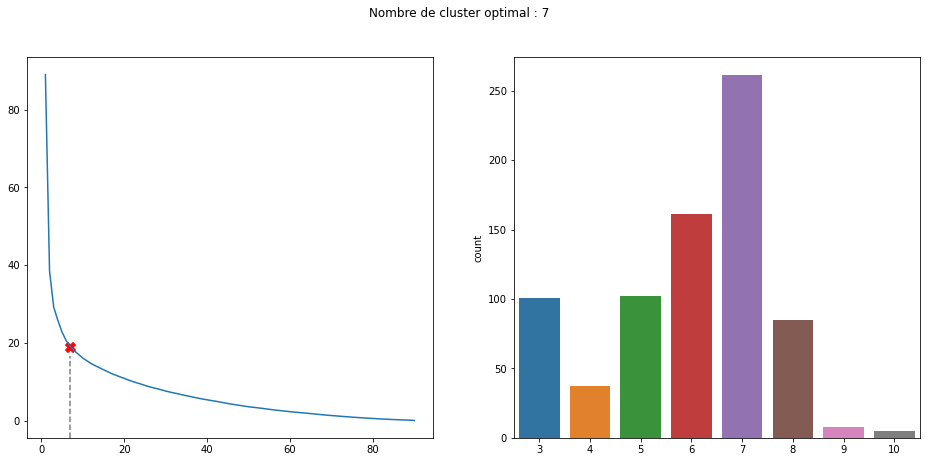

In [75]:
k_calc, results = f_clusters_coude(data, k_seuil= 15, k_end=90, n_init=5, nbre_tours=10)

## Création des clusters

In [89]:
# Choix du nombre de clusters à créer
nbre_clusters = 7

<AxesSubplot:xlabel='cluster', ylabel='count'>

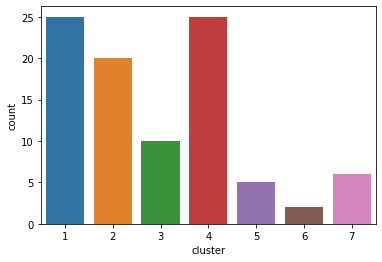

In [90]:
# Entrainement
cluster_table, cluster_centers = f_clusters_fit(data, nbre_clusters, n_init = 2000, max_iter = 500)

# répartition des piezos dans les clusters
sns.countplot(data = cluster_table, x = "cluster")

In [91]:
cluster_centers.head()

,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7
date_mesure,,,,,,,
2012-03-15,0.277960,-0.028220,-1.329795,-0.624019,0.851108,0.147591,-0.524659
2012-03-22,0.240158,0.007131,-1.347614,-0.687537,0.733497,0.103299,-0.520886
2012-03-29,0.056958,0.075189,-1.299056,-0.696771,0.791524,0.107437,-0.468168
2012-04-05,-0.005344,0.228528,-1.318039,-0.699813,0.550675,0.168216,-0.570401
2012-04-12,-0.006113,0.268299,-1.362394,-0.771297,0.659557,0.204935,-0.656478


In [92]:
cluster_table.head()

,cluster,MSE
code_bss,,
05068X0028_SP010,5,0.085719
04514X0018_01,1,0.064987
04808X0027_N11,4,0.621967
04555X0093_F1,1,0.333926
05078X0040_PZN1,1,0.172074


## Affichage des clusters

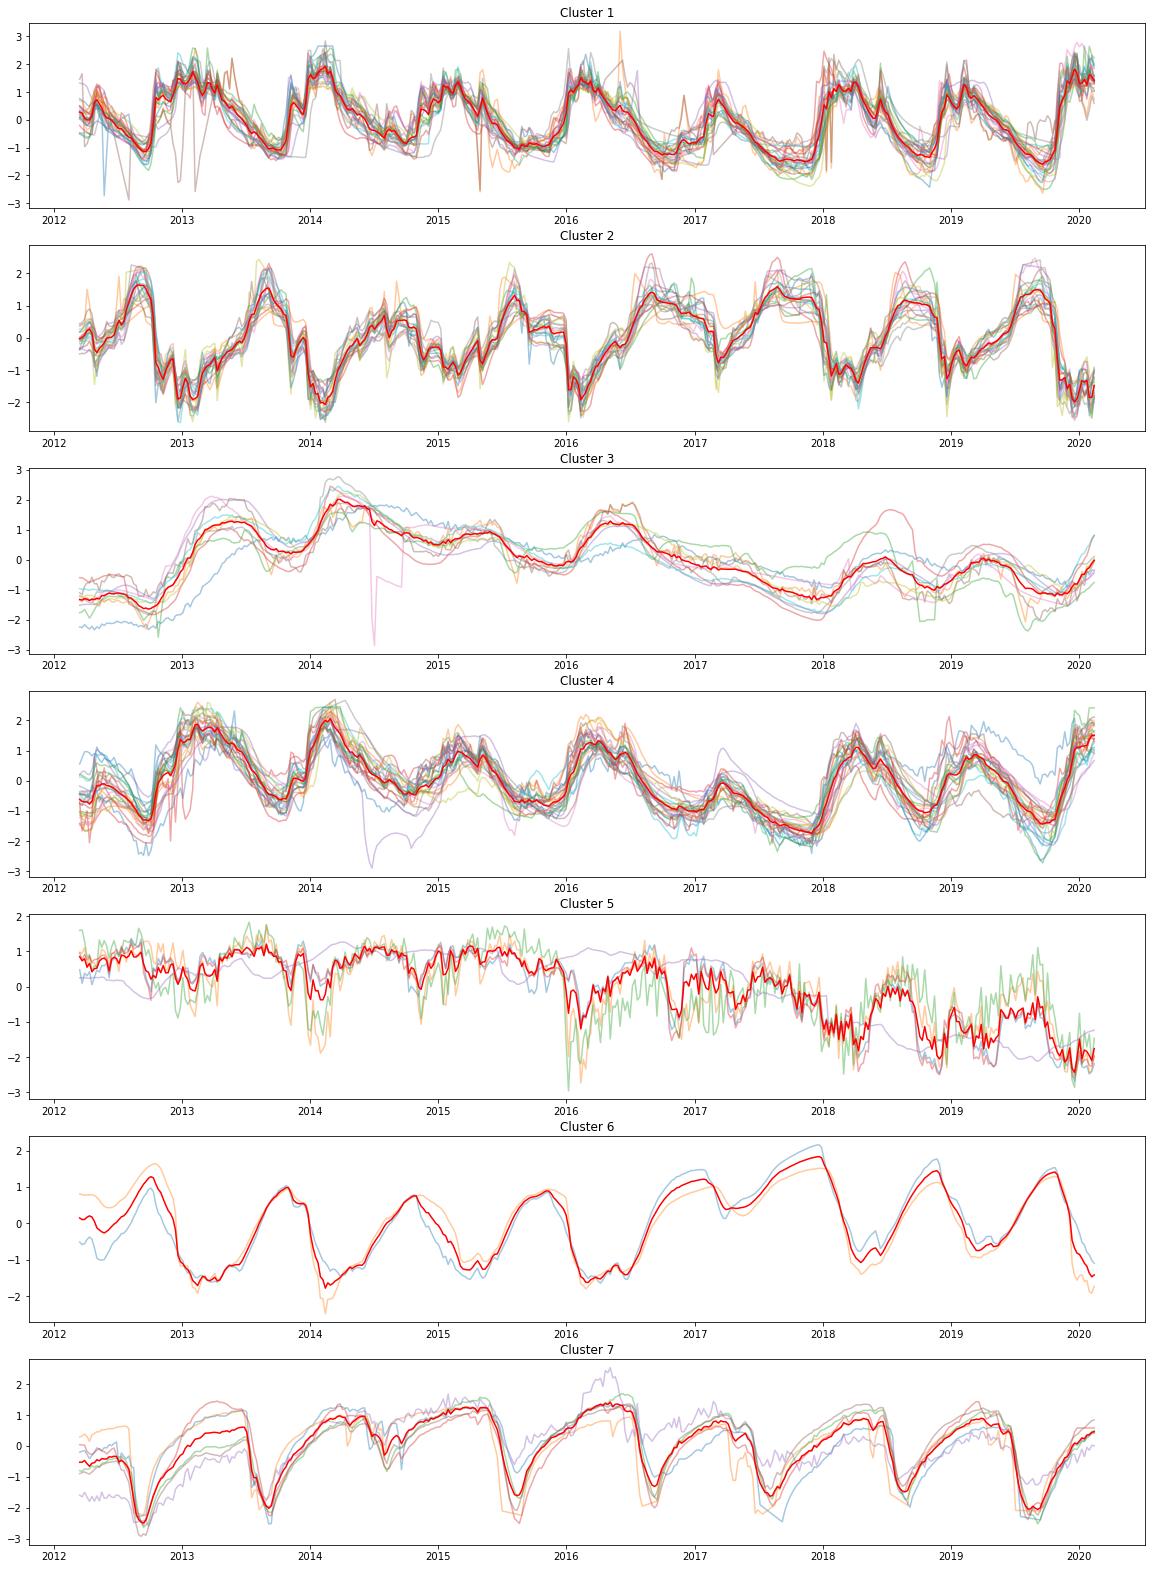

In [93]:
f_plot_clusters(data, cluster_table, cluster_centers)
#cluster_table.groupby("cluster").mean()

In [94]:
#f_plot_all(data, cluster_table, cluster_centers)

## Filtre des chroniques avec score insuffisant

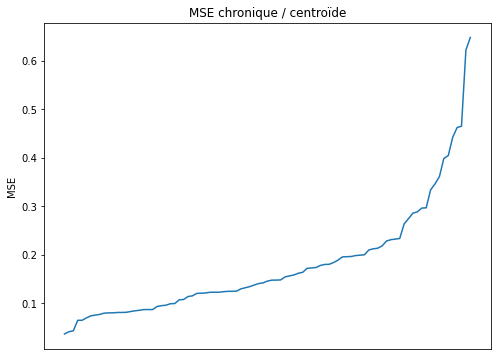

In [95]:
plt.figure(figsize=(8, 6))
ax = cluster_table["MSE"].sort_values().plot(title = "MSE chronique / centroïde")
ax.set_xlabel("")
ax.set_ylabel("MSE")
ax.tick_params(left = True, right = False , labelleft = True ,
                labelbottom = False, bottom = False)
plt.show()


Itération 1 : 7 chronique(s) éliminée(s).
Itération 2 : 2 chronique(s) éliminée(s).
Itération 3 : 0 chronique(s) éliminée(s).
Nombre total de chroniques éliminées : 9


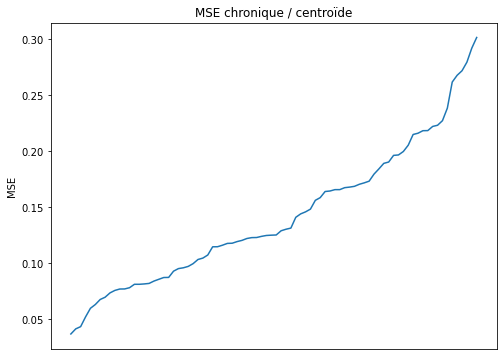

In [96]:
# nbre de chroniques sous le seuil
MSEmax = f_MSEmax(cluster_table)
cluster_table.loc[cluster_table.MSE > MSEmax, "cluster"] = 0

nbre_elim_total = 0
nbre_elim = cluster_table.loc[cluster_table.MSE > MSEmax, 'MSE'].count()
nbre_elim_total += nbre_elim

iteration = 1
print(f"Itération {iteration} : {nbre_elim} chronique(s) éliminée(s).")

data_opt = data.copy()

while nbre_elim != 0 :
    
    # Selection des clusters non zéro
    data_opt = data.copy().loc[:,cluster_table.loc[cluster_table.cluster != 0].index]
    
    # Nouveau clustering
    cluster_table, cluster_centers = f_clusters_fit(data_opt, nbre_clusters, n_init = 2000, max_iter = 500)

    # chroniques sous le seuil passées à cluster 0
    MSEmax = f_MSEmax(cluster_table)
    nbre_elim = cluster_table.loc[cluster_table.MSE > MSEmax, 'MSE'].count()   
    nbre_elim_total += nbre_elim
    

    cluster_table.loc[cluster_table.MSE > MSEmax, "cluster"] = 0
    iteration += 1
    print(f"Itération {iteration} : {nbre_elim} chronique(s) éliminée(s).")

    
for index, column in enumerate (cluster_centers.columns):
    cluster_centers.rename(columns={column : f"{index+1}"}, inplace=True)    
    
print(f"Nombre total de chroniques éliminées : {nbre_elim_total}")

plt.figure(figsize=(8, 6))
ax = cluster_table["MSE"].sort_values().plot(title = "MSE chronique / centroïde")
ax.set_xlabel("")
ax.set_ylabel("MSE")
ax.tick_params(left = True, right = False , labelleft = True ,
                labelbottom = False, bottom = False)
plt.show()


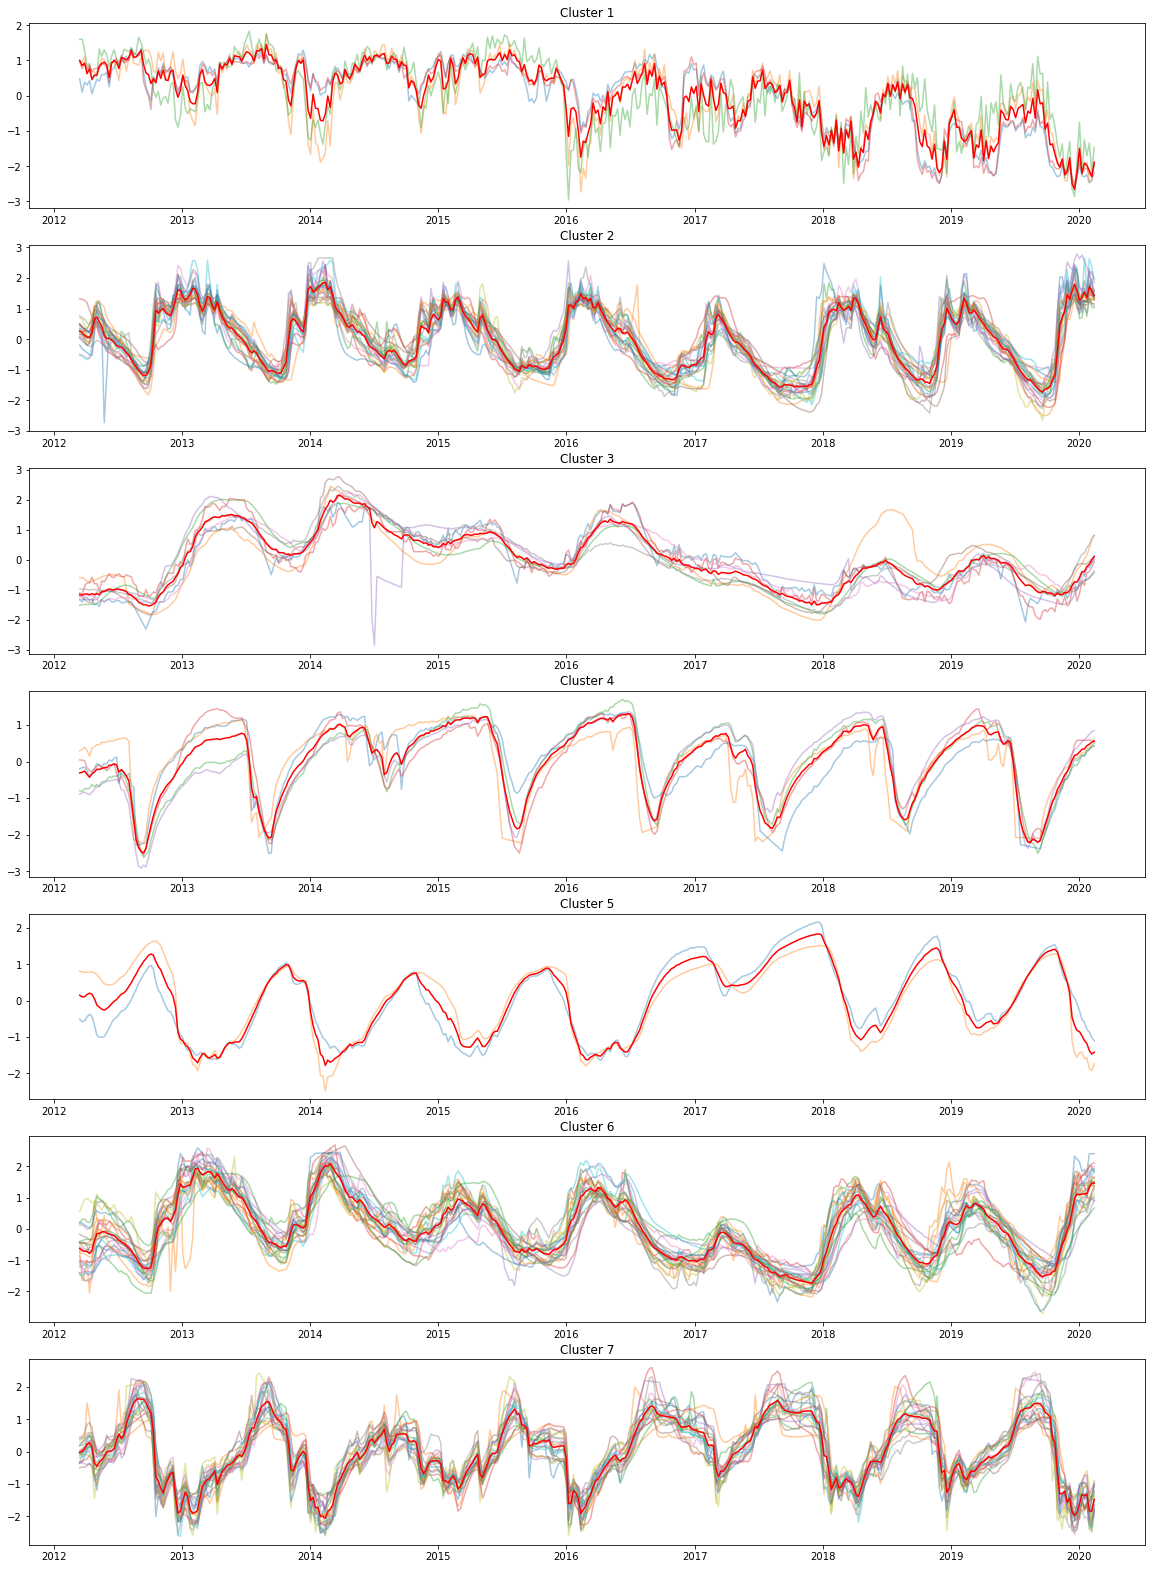

In [97]:
f_plot_clusters(data_opt, cluster_table, cluster_centers)

<AxesSubplot:xlabel='cluster', ylabel='count'>

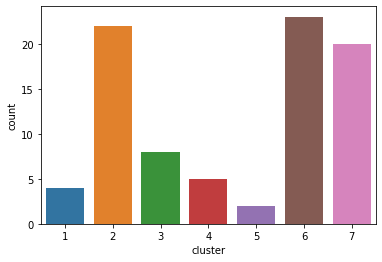

In [98]:
sns.countplot(data = cluster_table, x = "cluster")

## Sous-clusters - linkage / dendrogramme 

['C1', 'C1', 'C1', 'C1', 'C2', 'C2', 'C2']

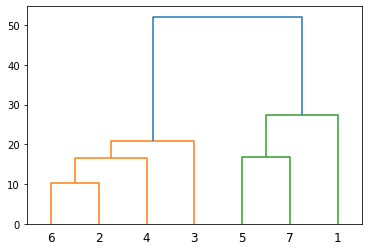

In [99]:
Z = hierarchy.linkage(cluster_centers.T, method='ward', optimal_ordering=True)
plt.figure()
dn = hierarchy.dendrogram(Z, 
                          labels=list(cluster_centers.columns),
                          count_sort = 'descending',
                          distance_sort = 'ascending',
                          get_leaves =True,
                          show_leaf_counts = True,
                          color_threshold = max(Z[:,2])*0.7)

cluster_order = dn.get('ivl')
codes_couleur = dn.get('leaves_color_list')
codes_couleur

In [100]:
# Décompte du nombre d'une même couleur présente consécutivement
compteur = [1]
index_compteur = 0
for index in range (1,len(codes_couleur)) :
    if codes_couleur[index] == codes_couleur[index-1] :
        compteur[index_compteur] += 1
    else :
        index_compteur += 1
        compteur.append(1)
        
ch = "A"
new_codes_couleur = []

for index, number in enumerate (compteur) :
    if number == 1 :
        new_codes_couleur.append(ch)
    else :
        for num_sc in range (1,number+1):
            new_codes_couleur.append(ch + str(num_sc))
    ch = chr(ord(ch)+1)
new_codes_couleur

['A1', 'A2', 'A3', 'A4', 'B1', 'B2', 'B3']

### Modification des libellés

In [101]:
# Conversion nom numérique en nom littéral

# - Cluster table
cluster_table.replace(list(map(int, cluster_order)), new_codes_couleur, inplace=True)

# - Cluster centers
dict_rename = dict(zip(cluster_order, new_codes_couleur))
cluster_centers.rename(columns=dict_rename, inplace=True)

In [102]:
cluster_table.head()

,cluster,MSE
code_bss,,
05068X0028_SP010,B3,0.131304
04514X0018_01,A2,0.052003
05078X0040_PZN1,A2,0.167865
06101X0202_SP1,B2,0.075684
03922X0027_S1,A1,0.081923


In [103]:
cluster_centers.head()

,B3,A2,A4,A3,B1,A1,B2
date_mesure,,,,,,,
2012-03-15,1.002003,0.266517,-1.160759,-0.311919,0.147591,-0.629286,-0.028220
2012-03-22,0.853553,0.217454,-1.183379,-0.296930,0.103299,-0.697222,0.007131
2012-03-29,0.925368,0.136763,-1.145638,-0.262542,0.107437,-0.713995,0.075189
2012-04-05,0.628617,0.070639,-1.139880,-0.353210,0.168216,-0.722493,0.228528
2012-04-12,0.765437,0.057750,-1.169958,-0.430349,0.204935,-0.791185,0.268299


# Enregistrement des profils des clusters

In [104]:
cluster_centers.to_csv(f"./data/{region}_clusters.csv")

# Ajout à la bdd

In [105]:
# Nom de la table
table = "cluster_kmeans"

In [106]:
# Création de la table
requete = f"""
                    ALTER TABLE data_piezo
                    ADD {table} VARCHAR(6) DEFAULT NULL
                    """
f_requete_sql(requete)

Connexion réussie à SQLite
Erreur lors du mis à jour dans la table duplicate column name: cluster_kmeans


In [107]:
# Création de listes de nuéro de cluster avec le nom des piezos
# Ajout dans la bdd
for label in set(cluster_table.cluster):
    cluster = tuple(cluster_table.loc[cluster_table.cluster == label, 'cluster'].index.to_list())
    requete = f"""
        UPDATE data_piezo
        SET {table} = '{region}_{label}'
        WHERE code_bss IN {cluster}
        """
    f_requete_sql(requete)

Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion réussie à SQLite
Connexion SQLite est fermée


## Suppresion colonne

requete = """
                    ALTER TABLE data_piezo
                    DROP cluster_kmeans
                    """
f_requete_sql(requete)

# Chronique caractéristique des clusters

In [108]:
# Recherche du code_bss avec la valeur MSE la plus faible
liste_top_bss = []
for cluster in cluster_table.cluster.unique() :
    liste_top_bss.append(cluster_table.loc[cluster_table.cluster == cluster].sort_values("MSE").index[0])
df_top = pd.DataFrame(liste_top_bss, cluster_table.cluster.unique(), columns=["code_bss"])

df_top = df_top.sort_index()

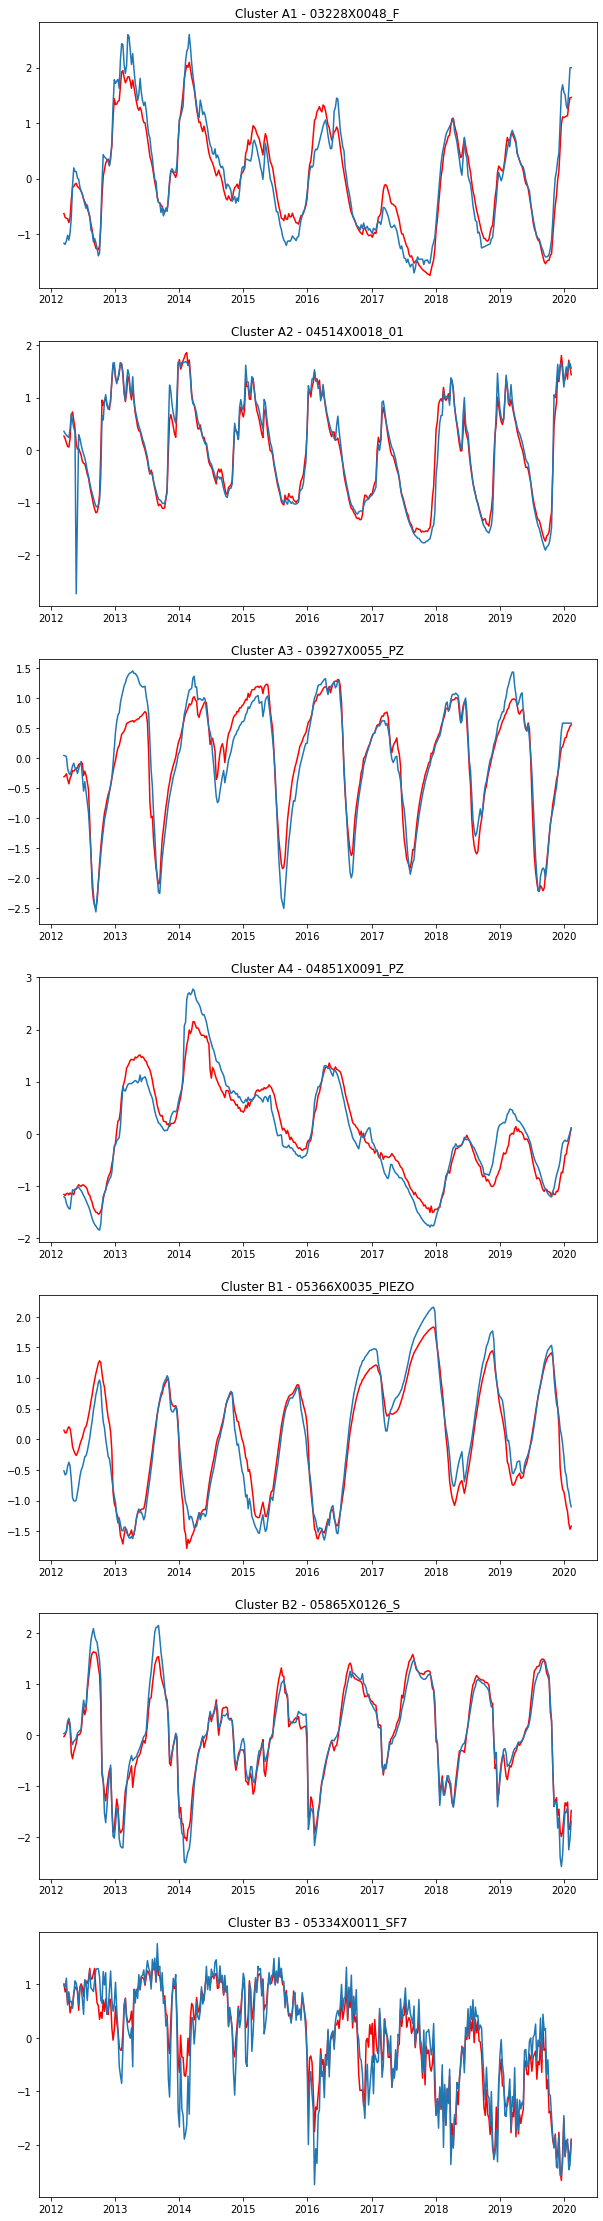

In [109]:
fig, axs = plt.subplots(len(df_top),1,figsize=(10,40))
for i in range (len(df_top)):
    cluster = df_top.index[i]
    bss = df_top.code_bss[i]
    axs[i].plot(cluster_centers.loc[:,cluster], 'red')
    axs[i].plot(data_opt.loc[:,bss])
    axs[i].set_title("Cluster "+ cluster + " - " + bss)    
                

## Ajout à la bdd

In [112]:
code_cluster = tuple(region + "_" +  df_top.index)
code_bss = tuple(df_top.index)
tableau = list(np.stack((code_cluster,code_bss), axis=1))
for index, line in enumerate(tableau):
    tableau[index] = tuple(line)

In [113]:
# Création de la table
requete = f"""
            CREATE TABLE IF NOT EXISTS flagship_piezo (
            code_cluster VARCHAR(8) PRIMARY KEY ON CONFLICT IGNORE,
            code_bss VARCHAR(8)
            )
            """
f_requete_sql(requete)

Connexion réussie à SQLite
Connexion SQLite est fermée


[]

In [114]:
requete = f"INSERT INTO flagship_piezo (code_cluster, code_bss) VALUES (?,?)"

try:
    connexion = sqlite3.connect('../data/liste_piezos.db')
    curseur = connexion.cursor()
    print("Connexion réussie à SQLite")
    curseur.executemany(requete, tableau)
    connexion.commit()
    resultat = curseur.fetchall()
    curseur.close()
    connexion.close()
    print("Connexion SQLite est fermée")
except sqlite3.Error as error:
    print("Erreur lors du mis à jour dans la table : ", error)

Connexion réussie à SQLite
Connexion SQLite est fermée


### Suppression données region

In [111]:
# Création de la table
requete = f"""
            DELETE FROM flagship_piezo
            WHERE code_cluster LIKE '{region}%'
            """
f_requete_sql(requete)

Connexion réussie à SQLite
Connexion SQLite est fermée


[]